### Example 16 - Testing Market Making Strategies

In this example, we'll create and test a simple market making strategy using the market making targets we discovered in Example 14.  There are three basic steps we need to perform to test a strategy:

1. Prepare market data samples for the strategy.
2. Write the strategy.  See the text for details on how strategies are written.
3. Initialize and run the simulator with our prepared market data and our strategy.

We'll work through these steps below, spending more time towards the end analyzing the output of our simulations.

**NOTE:** our simulator uses the simpy package (https://simpy.readthedocs.io/) to implement discrete event simulation.  You'll need to import this package into your environment in order for the simulator to work correctly.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import datetime
import scipy.interpolate
import numpy.random
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time
# Simulation imports
from evekit.sim import MMSimOMS, MMOrderStatus, MMSimStrategyBase
import simpy

In [2]:
# As in previous examples, we'll consider opportunities in The Forge at the busiest station in Jita.
# Although our strategy will be written generically and should work with any asset type, we'll prepare
# data for the eight types we discovered in Example 14.  We set the appropriate constants in the code below.
#
# We'll prepare the simulation using the same date range as in Example 14, namely every Saturday
# from 2017-01-07 through 2017-05-20.
#
sde_client = Client.SDE.get()
region_query = "{values: ['The Forge']}"
station_query = "{values: ['Jita IV - Moon 4 - Caldari Navy Assembly Plant']}"
region_id = sde_client.Map.getRegions(regionName=region_query).result()[0][0]['regionID']
station_id = sde_client.Station.getStations(stationName=station_query).result()[0][0]['stationID']
date_range = pd.date_range(datetime.datetime(2017, 1, 7), datetime.datetime(2017, 5, 20))
sat_date_range = [x for x in date_range if x.weekday() == 5]
sim_types = [8027, 8089, 8105, 8433, 8529, 11105, 16303, 16527]
print("Using region_id=%d, station_id=%d from %s to %s" % (region_id, station_id, str(date_range[0]), str(date_range[-1])))

Using region_id=10000002, station_id=60003760 from 2017-01-07 00:00:00 to 2017-05-20 00:00:00


In [3]:
# Retrieve type information for our target types
market_type_map = {}
type_query = "{values:[" + ",".join([str(x) for x in sim_types]) + "]}"
for x in Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_query):
    market_type_map[x['typeID']] = x
len(market_type_map.keys())

8

In [4]:
# As in Example 14, we need to commpute a volume threshold series for each type which will help us distinguish 
# between large orders and cancels.  Note that our threshold computer requires a window of five days which means 
# we need to include the four Saturdays prior to the start of our date range.  We construct this extended range
# and download appropriate market history for our target sim type.
#
from evekit.marketdata import MarketHistory
ext_date_range = [datetime.datetime(2016, 12, 10), datetime.datetime(2016, 12, 17),
                  datetime.datetime(2016, 12, 24), datetime.datetime(2016, 12, 31)] + sat_date_range
market_history = MarketHistory.get_data_frame(dates=ext_date_range, types=sim_types, regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-12-10 00:00:00...done
Retrieving 2016-12-17 00:00:00...done
Retrieving 2016-12-24 00:00:00...done
Retrieving 2016-12-31 00:00:00...done
Retrieving 2017-01-07 00:00:00...done
Retrieving 2017-01-14 00:00:00...done
Retrieving 2017-01-21 00:00:00...done
Retrieving 2017-01-28 00:00:00...done
Retrieving 2017-02-04 00:00:00...done
Retrieving 2017-02-11 00:00:00...done
Retrieving 2017-02-18 00:00:00...done
Retrieving 2017-02-25 00:00:00...done
Retrieving 2017-03-04 00:00:00...done
Retrieving 2017-03-11 00:00:00...done
Retrieving 2017-03-18 00:00:00...done
Retrieving 2017-03-25 00:00:00...done
Retrieving 2017-04-01 00:00:00...done
Retrieving 2017-04-08 00:00:00...done
Retrieving 2017-04-15 00:00:00...done
Retrieving 2017-04-22 00:00:00...done
Retrieving 2017-04-29 00:00:00...done
Retrieving 2017-05-06 00:00:00...done
Retrieving 2017-05-13 00:00:00...done
Retrieving 2017-05-20 00:00:00...done


In [5]:
# Now we can compute the thresholds we need for trade inferrence
#
volume_thresh_multiplier = 0.04
volume_thresh_map = {}
for next_type in market_history.groupby(market_history.type_id):
    group_id = next_type[0]
    group_df = next_type[1]
    volume_thresh_map[group_id] = group_df.volume.rolling(window=5, center=False).mean() * volume_thresh_multiplier

In [6]:
# We're now ready to extract order information.  We'll use the order extractor we created in Example 15.
#
# The result of this function will be a tuple (ref_price, ref_spread, order_series, trade_series) 
# where ref_price is the reference price chosen for the day; ref_spread is the reference difference
# between the best bid and ask for the chosen day; order_series is the series of orders 
# arriving, changed or canceled from the book; and, trade_series is the series of trades 
# inferred from the book.
#
def collect_book_changes(type_id, dt, order_book, volume_threshold_map):
    order_series = []
    trade_series = []
    by_type = order_book[order_book.type_id == type_id]
    vol_limit = volume_threshold_map[type_id][dt]
    #
    # Convenience function to copy an order
    #
    def copy_order(order):
        return dict(buy=order['buy'], duration=order['duration'], issued=order['issued'], location_id=order['location_id'],
                    min_volume=order['min_volume'], order_id=order['order_id'], region_id=order['region_id'], 
                    type_id=order['type_id'], volume=order['volume'], volume_entered=order['volume_entered'])
    #
    # Determine a reference price from the spread mid-point in the first snapshot.  The reference point can be
    # arbitrary as long as we are consistent.
    #
    first_snap = by_type.ix[by_type.index[0]]
    best_bid = first_snap[first_snap.buy == True]
    best_ask = first_snap[first_snap.buy == False]
    ref_price = 0
    ref_spread = 0
    if len(best_ask) > 0 and len(best_bid) > 0:
        ref_price = (best_ask.ix[0].price + best_bid.ix[0].price) / 2
        ref_spread = best_ask.ix[0].price - best_bid.ix[0].price
    elif len(best_ask) > 0:
        ref_price = best_ask.ix[0].price / 2
        ref_spread = ref_price * 0.1
    elif len(best_bid) > 0:
        ref_price = best_bid.ix[0].price
        ref_spread = ref_price * 0.1
    #
    # Iterate over consecutive book snapshots looking for order book changes.
    #
    snap_list = list(by_type.groupby(by_type.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        current_time = current[0]
        next_snap = next[1]
        next_time = next[0]
        # Look for new orders added in the next snapshot
        new_id_set = set(next_snap.order_id).difference(set(current_snap.order_id))
        if len(new_id_set) > 0:
            for next_row in next_snap.iterrows():
                if next_row[1]['order_id'] in new_id_set:
                    cp_order = copy_order(next_row[1])
                    cp_order['time'] = next_time
                    cp_order['action'] = 'new'
                    # Indicate whether this order entereed at the top of the book
                    by_side = next_snap[next_snap.buy == cp_order['buy']]
                    cp_order['tob'] = by_side.ix[0]['order_id'] == cp_order['order_id']
                    order_series.append(cp_order)
        # Look for volume changes.  These are trades.
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        for next_change in changed_orders.index:
            # Create the trade object
            next_line = changed_orders.ix[next_change]
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            trade_series.append(dict(time=next_time, buy=next_line.buy_x, order_id=next_line.order_id,
                                     volume=amount, location=str(location)))
        # Now handle order price changes.
        changed_orders = merged[merged.price_x != merged.price_y]
        for next_change in changed_orders.index:
            # Create the order object
            next_line = changed_orders.ix[next_change]
            cp_order = dict(buy=next_line['buy_x'], duration=next_line['duration_x'], issued=next_line['issued_x'], 
                            location_id=next_line['location_id_x'], min_volume=next_line['min_volume_x'], 
                            order_id=next_line['order_id'], region_id=next_line['region_id_x'], 
                            type_id=next_line['type_id_x'], volume=next_line['volume_x'], 
                            volume_entered=next_line['volume_entered_x'], time=next_time, action='change')
            order_series.append(cp_order)
        # Look for removed orders.  These are either a fully filled order or a cancel.
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            next_line = current_snap[current_snap.order_id == order_id].ix[current[0]]
            # If the volume of a removed order does not exceed the threshold, then keep it.
            if next_line.volume <= vol_limit:
                location = next_line.location_id
                if next_line.buy and next_line.order_range != 'station':
                    # See above
                    location = None
                trade_series.append(dict(time=next_time, buy=next_line.buy, order_id=next_line.order_id,
                                         volume=next_line.volume, location=str(location)))
            else:
                # Save as a canceled order
                cp_order = copy_order(next_line)
                cp_order['time'] = next_time
                cp_order['action'] = 'cancel'
                order_series.append(cp_order)
    # Return result
    return (ref_price, ref_spread, order_series, trade_series)

In [7]:
# To prepare market data for our simulation, we need to extract and aggregate order information
# for every date in our date range.  We collect the results into an array, then aggregate in
# the next cell.
#
from evekit.marketdata import OrderBook
#
market_data_prep = {}

for next_type in sim_types:
    market_data_prep[next_type] = []

for next_date in sat_date_range:
    order_book = OrderBook.get_data_frame(dates=[next_date], types=sim_types, regions=[region_id], 
                                          config=dict(local_storage=".", tree=True, skip_missing=True, 
                                                      fill_gaps=True, verbose=True))
    # Reduce to just the local station
    order_book = order_book[order_book.location_id == station_id]
    # Extract and save order information
    for next_type in sim_types:
        market_data_prep[next_type].append(collect_book_changes(next_type, next_date, order_book, volume_thresh_map))

Retrieving 2017-01-07 00:00:00...done
Retrieving 2017-01-14 00:00:00...done
Retrieving 2017-01-21 00:00:00...done
Retrieving 2017-01-28 00:00:00...done
Retrieving 2017-02-04 00:00:00...done
Retrieving 2017-02-11 00:00:00...done
Retrieving 2017-02-18 00:00:00...done
Retrieving 2017-02-25 00:00:00...done
Retrieving 2017-03-04 00:00:00...done
Retrieving 2017-03-11 00:00:00...done
Retrieving 2017-03-18 00:00:00...done
Retrieving 2017-03-25 00:00:00...done
Retrieving 2017-04-01 00:00:00...done
Retrieving 2017-04-08 00:00:00...done
Retrieving 2017-04-15 00:00:00...done
Retrieving 2017-04-22 00:00:00...done
Retrieving 2017-04-29 00:00:00...done
Retrieving 2017-05-06 00:00:00...done
Retrieving 2017-05-13 00:00:00...done
Retrieving 2017-05-20 00:00:00...done


In [8]:
# Our market simulation requires as input a reference price, a reference spread, a collection of order samples and
# a collection of trade samples.  We generate the first two inputs by taking the average of the corresponding data
# from the historic data we just aggregated.
#
avg_ref_price = {}
avg_ref_spread = {}
for next_type in sim_types:
    avg_ref_price[next_type] = np.mean([x[0] for x in market_data_prep[next_type]])
    avg_ref_spread[next_type] = np.mean([x[1] for x in market_data_prep[next_type]])
#
# Orders and trades require more care because dates will reference the date of the order book from which the
# data was referenced.  However, as we demonstrated in the previous example, inter-arrival times are constructed
# by computing the difference between subsequent events.  This will cause a problem between days in our date
# range which are separated by a week.  Therefore, we'll adjust dates in our extracted data so that the collection
# of orders and trades appear to occur on consecutive days.
#
order_collection = {}
trade_collection = {}
for next_type in sim_types:
    order_collection[next_type] = [x.copy() for x in market_data_prep[next_type][0][2]]
    trade_collection[next_type] = [x.copy() for x in market_data_prep[next_type][0][3]]
    date_correction = [sat_date_range[x] - sat_date_range[0] - pd.Timedelta(days=x) for x in range(1, len(sat_date_range))]
    for i in range(1, len(sat_date_range)):
        for next_order in market_data_prep[next_type][i][2]:
            order_copy = next_order.copy()
            order_copy['time'] -= date_correction[i - 1]
            order_collection[next_type].append(order_copy)
        for next_trade in market_data_prep[next_type][i][3]:
            trade_copy = next_trade.copy()
            trade_copy['time'] -= date_correction[i - 1]
            trade_collection[next_type].append(trade_copy)

In [9]:
# The simulator expects market data configuration as a map from type_id to the data we computed
# above.  We create that map here:
#
market_data_map = {}
for next_type in sim_types:
    market_data_map[next_type] = {
        'ref_price': avg_ref_price[next_type],
        'ref_spread': avg_ref_spread[next_type],
        'trades': trade_collection[next_type],
        'orders': order_collection[next_type]
    }

In [10]:
# We're now ready to design our market making strategy for test.  Instructions on how to implement 
# a strategy are given in the book text.  For this example, we'll implement a very simple strategy:
#
# 1. We start by waiting for an order book snapshot in which the spread is profitable for trading.
# 2. Next, we'll buy a set number of units of the type we wish to trade.
# 3. Until our buy is filled, we'll change our buy order as needed to ensure we capture the best bid.
# 4. After our buy is filled, we'll immediately place a sell.
# 5. Until our sell is filled, we'll change our sell order as needed to ensure we capture the best ask.
# 6. Once our sell is filled, we'll go back to step one and repeat until the simulation completes.
#
# Here's the strategy:
#
class RoundTripStrategy(MMSimStrategyBase):

    def __init__(self, oms, tax_rate, broker_rate, order_change_fee, type_id, units, verbose=False):
        super().__init__(oms, tax_rate, broker_rate, order_change_fee)
        self.type_id = type_id
        self.units = units
        self.verbose = verbose

    def run(self, env):
        # Save the appropriate price ratio we need before we should enter a round of market making.
        # This is just the formula described in the text.
        #
        price_ratio_target = (1 + self.broker_rate) / (1 - self.tax_rate - self.broker_rate)
        try:
            while True:
                #
                # Wait for the first snapshot with a profitable spread ratio.
                #
                buy_order = None
                while buy_order is None:
                    order_book = yield self.oms.order_book(self.type_id)
                    top_bid = self.best_bid(order_book)
                    top_ask = self.best_ask(order_book)
                    if top_bid is None or top_ask is None:
                        # Spread not available
                        continue
                    if top_ask / top_bid <= price_ratio_target:
                        # Spread not profitable
                        continue
                    price = top_bid + 0.01 if top_bid is not None else 0.01
                    buy_order = self.tracked_order(self.type_id, 30, True, price, self.units, 1)
                    if self.verbose:
                        print(str(env.now) + " Buy order placed at " + str(price))
                #
                # Wait for buy order to be filled, making sure we always capture the best bid.
                # When the order is filled, turn around and post a sale.
                #
                sell_order = None
                c1, c2 = buy_order.closed(), self.oms.order_book(self.type_id)
                while sell_order is None:
                    result = yield c1 | c2
                    # Check for order status change first to avoid racing with new order book
                    if c1 in result:
                        # Order closed, if it was filled then place our sell order
                        if buy_order.status != MMOrderStatus.FILLED:
                            # Something unexpected happened, exit sim
                            raise Exception("Buy order in unexpected state: " + str(buy_order.status))
                        if self.verbose:
                            print(str(env.now) + " Buy order completed")
                        # The final price of our buy order gives us the minimum price for which we
                        # must sell the assets.  This equation is also described in the text.
                        minimum_sell_price = buy_order.price * (1 + self.broker_rate) / \
                                                               (1 - self.tax_rate - self.broker_rate)
                        order_book = self.oms.get_current_order_book(self.type_id)
                        top_ask = self.best_ask(order_book)
                        price = top_ask - 0.01 if top_ask is not None else 1000000000
                        price = max(price, minimum_sell_price)
                        sell_order = self.tracked_order(self.type_id, 30, False, price, self.units, 1)
                        if self.verbose:
                            print(str(env.now) + " Sell order placed at " + str(price))

                    if c2 in result and sell_order is None:
                        # Make sure we still own the best bid
                        order_book = result[c2]
                        new_price = self.promote_order(buy_order, order_book)
                        if self.verbose and new_price is not None:
                            print(str(env.now) + " Buy order price changed to " + str(new_price))
                        # Reset for next order book
                        c2 = self.oms.order_book(self.type_id)
                #
                # Wait for sell order to be filled, making sure we always capture best ask.
                #
                c1, c2 = sell_order.closed(), self.oms.order_book(self.type_id)
                while True:
                    result = yield c1 | c2
                    # Check for order status change first to avoid racing with new order book
                    if c1 in result:
                        if sell_order.status != MMOrderStatus.FILLED:
                            # Something unexpected happened, exit sim
                            raise Exception("Sell order in unexpected state: " + str(sell_order.status))
                        # Done, exit strategy
                        if self.verbose:
                            print(str(env.now) + " Sell order completed")
                        break

                    if c2 in result and sell_order.status == MMOrderStatus.OPEN:
                        # Make sure we still own the best ask
                        order_book = result[c2]
                        new_price = self.promote_order(sell_order, order_book, side_limit=minimum_sell_price)
                        if self.verbose and new_price is not None:
                            print(str(env.now) + " Sell order price changed to " + str(new_price))
                        # Reset for next order book
                        c2 = self.oms.order_book(self.type_id)
        except simpy.Interrupt:
            # allow us to be interrupted, we just stop when this happens
            pass

In [11]:
# We're now ready to run our simulation.  The simulator requires a few constants and a small amount of setup.
#
# First, we need to define rate and fee constants:
#
sim_tax_rate = 0.01
sim_broker_rate = 0.025
sim_change_fee = 100
#
# Next, we need to choose a seed for our random number generators.  Later, we'll re-run our simulation several times
# with different seeds in order to generate statistically significant results.
#
seed = 5678
#
# Finally, we can setup simpy and run a simulation for a day.  For this first run, we'll set verbose to True
# so that simulation actions are clear.
#
env = simpy.Environment()
#
# Initialize order management system
#
sim_oms = MMSimOMS(env, market_data_map, sim_tax_rate, sim_broker_rate, sim_change_fee, seed)
#
# Initialize strategy to test.  For this first test, we'll simulate trading only the first of
# the eight asset types we have data for.  The other asset types will trade, but our strategy will
# not participate in those trades.  We've instructed the strategy to buy 10 units at a time.
# We'll derive a better way to estimate the appropriate unit volume further below.
# We've also turned on verbose mode so we can see the strategy operating.
#
strategy = RoundTripStrategy(sim_oms, sim_tax_rate, sim_broker_rate, sim_change_fee, sim_types[0], 10, True)
#
# Create a simpy process to drive the strategy
#
env.process(strategy.run(env))
#
# Kickoff the simulation.  Time values represent seconds.  In this case, we're running the simulation
# for one simulated day of trading.
#
env.run(until=86400)
#
# Print sim results summaries
#
print()
print(str(sim_oms))
print()
print(str(strategy.strategy_summary()))

300 Buy order placed at 1429103.32
600 Buy order price changed to 1429103.34
900 Buy order price changed to 1429103.36
2100 Buy order price changed to 1429103.38
2400 Buy order price changed to 1429103.41
2700 Buy order price changed to 1429103.45
3600 Buy order price changed to 1429103.47
4237 Buy order completed
4237 Sell order placed at 1561701.48
4500 Sell order price changed to 1561701.46
5100 Sell order price changed to 1561701.44
5700 Sell order price changed to 1561701.42
6000 Sell order price changed to 1561701.4
6600 Sell order price changed to 1561701.38
6900 Sell order price changed to 1561701.36
7500 Sell order price changed to 1561701.34
7800 Sell order price changed to 1561701.32
8100 Sell order price changed to 1561701.3
9300 Sell order price changed to 1561701.28
10200 Sell order price changed to 1561701.26
10800 Sell order price changed to 1561701.24
11700 Sell order price changed to 1561701.22
12300 Sell order price changed to 1561701.2
12600 Sell order price changed

The OMS trade summary shows the overall stats for each asset type we simulated.  Although our strategy only traded one asset type, the simulator dutifully simulated all eight assets we provided data for, so there are eight rows.  The strategy trading summary replays our strategy's trade activity.  The same information is also available as a DataFrame which also includes information such as the timestamps when trades occured.  We'll use the DataFrame in a later cell.

In terms of performance, our strategy ended the day with an open sell order.  If we backtrack to the last completed sell order, we show a total profit and loss \(PNL\) of about 3.7M ISK \(we'll discuss how to report around open orders below\).  It's interesting to note that in an entire day of trading, our strategy only traded a volume of 100 units \(50 bought, and 50 sold\), excluding the last buy and open sell.  These results may be an outlier, or they may be typical.  The only way to know for sure is to run more simulations with different random seeds to see if the results are different.  We'll do this next.  

In [12]:
# We'll run the simulation a total of 100 times, with random seeds, then we'll average the PNL results.
# It's easier to collect this data using the DataFrame version of the strategy summary.  We can get that
# information as follows.  The index here is the simulation type at which the buy or sell occurred.
#
strategy_df = strategy.order_dataframe()
strategy_df

,broker_fee,buy,gross,price,status,tax,time,type_id,volume,volume_remaining
300,357875.8600,True,-14291034.40,1429103.47,MMOrderStatus.FILLED,0.0000,300,8027,10,0
4237,392125.3700,False,15617012.54,1561701.14,MMOrderStatus.FILLED,156170.1254,4237,8027,10,0
16500,357275.8075,True,-14291032.30,1429103.23,MMOrderStatus.FILLED,0.0000,16500,8027,10,0
19089,390625.2975,False,15617011.64,1561701.15,MMOrderStatus.FILLED,156170.1164,19089,8027,10,0
20100,357975.8295,True,-14291033.18,1429103.37,MMOrderStatus.FILLED,0.0000,20100,8027,10,0
26174,390725.2850,False,15617011.14,1561701.08,MMOrderStatus.FILLED,156170.1114,26174,8027,10,0
41400,324740.8730,True,-12985634.92,1298563.51,MMOrderStatus.FILLED,0.0000,41400,8027,10,0
43545,390825.2625,False,15617009.88,1561700.97,MMOrderStatus.FILLED,156170.0988,43545,8027,10,0
63900,350537.6900,True,-14021507.60,1402150.76,MMOrderStatus.FILLED,0.0000,63900,8027,10,0
65122,391225.2075,False,15617006.92,1561700.68,MMOrderStatus.FILLED,156170.0692,65122,8027,10,0


In [13]:
# In this form of the data, the fees and gross returns are broken out separately.  We need to perform
# a running sum to produce PNL which we can do as follows:
#
(strategy_df.gross - strategy_df.tax - strategy_df.broker_fee).sum()
#
# This computation works as long as the last order is a filled sell order.  Otherwise, the simulation
# may end with an open buy or sell order.  We'll need to remove these trailing orders in order
# to get a more accurate view of PNL.  The following function computes PNL from the results
# DataFrame adjusting for such orders.
#
def compute_PNL(df):
    if len(df.iloc[:]) == 0:
        return 0
    last_offset = len(df.iloc[:]) - 1
    if df.iloc[last_offset]['status'] == MMOrderStatus.OPEN:
        last_offset -= 1
    if df.iloc[last_offset]['buy']:
        last_offset -= 1
    pnl_df = df.iloc[:last_offset + 1]
    return (pnl_df.gross - pnl_df.tax - pnl_df.broker_fee).sum()

# Now we can apply this function to show PNL
#
"{0:,.2f}".format(compute_PNL(strategy_df))

'3,720,026.72'

In [14]:
# We're now ready to run more simulations from which we'll aggregate results and look
# at a few statistical performance measures.  We'll perform a total of 100 runs, each 
# with a random seed.
#
seed_generator = numpy.random.RandomState(seed)
seeds = seed_generator.randint(1, 100000, 100)

In [15]:
# Now we'll loop the simulator collecting PNL results for each run.  The loop will take several minutes to finish.
# We'll use the same parameters as before, i.e. only simulating the first asset type with a unit size of 10.
# We've turned off verbose output for these runs.
#
pnl_array = []
for seed in seeds:
    print(".", end='')
    env = simpy.Environment()
    sim_oms = MMSimOMS(env, market_data_map, sim_tax_rate, sim_broker_rate, sim_change_fee, seed)
    strategy = RoundTripStrategy(sim_oms, sim_tax_rate, sim_broker_rate, sim_change_fee, sim_types[0], 10)
    env.process(strategy.run(env))
    env.run(until=86400)
    pnl_array.append(compute_PNL(strategy.order_dataframe()))
print()

....................................................................................................


In [16]:
# Let's look at a summary of the results.
#
print("{0:>15s} {1:>15s} {2:>15s} {3:>15s} {4:>15s}".format("min", "max", "mean", "median", "std"))
print("{0:15,.2f} {1:15,.2f} {2:15,.2f} {3:15,.2f} {4:15,.2f}".format(np.min(pnl_array),
                                                           np.max(pnl_array),
                                                           np.mean(pnl_array),
                                                           np.median(pnl_array),
                                                           np.std(pnl_array)))

            min             max            mean          median             std
     918,147.94   49,152,973.37   12,442,735.43   10,406,587.34    9,111,666.78


Our span of 100 runs shows a wide range in performance.  The mean and median are reasonably close which suggests a well behaved distribution of results.  The standard deviation is rather large suggesting high variance around the mean.  Of course, we can simply build a histogram of the data to see if the shape matches our intuition.

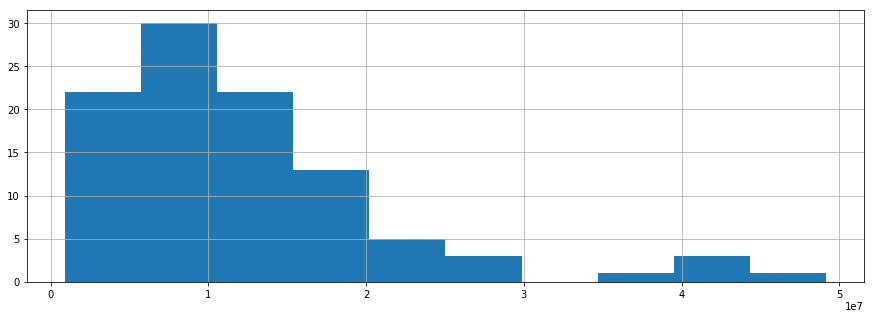

In [17]:
pd.Series(pnl_array).hist(figsize=[15,5])

This shape suggests a slightly exponential distribution which would allow further predicative analysis given more simulation runs.  We'll leave such analysis as an exercise to the reader.

Another dimension we can consider is the size of our orders.  For our initial run, we chose 10 units as the size of our market making round trips.  A better choice is to base the size according to the typical trade volume seen at our target station.  For a typical active asset, we might be able to capture 10% of the total volume for ourselves.  As we'll plan to make multiple market making round trips, that's still too large for a single order.  We might therefore plan to take 10% of that value as well, allowing us to make around 10 market making round trips in a typical trading session.  In other words, we might estimate a reasonable unit size to be 1% of total volume for a target asset.

We can compute these values based on our raw input market data.  For this example, we'll set the unit size to 1% of the average daily trade volume across our raw input data:

In [18]:
# Create a map from asset type to a reasonable unit size for that type.
#
unit_size_map = {}
for next_type in sim_types:
    mdf = pd.DataFrame(market_data_map[next_type]['trades'], index=[x['time'] for x in market_data_map[next_type]['trades']])
    unit_size_map[next_type] = int(max(1, mdf.groupby(pd.TimeGrouper('D')).volume.sum().mean() * 0.1 * 0.1))

In [19]:
# We can test this unit size with another round of simulations.  Here, we'll run
# a series of simulations for half the recommended order size, the exact order size,
# and 1.5 times the recommended order size, then compare results.  We'll execute these
# simulations only for the first type again.
#
vol_size_mult = [0.5, 1, 1.5]
size_pnl_array = []
for size_mult in vol_size_mult:
    next_pnl_array = []
    unit_size = int(unit_size_map[sim_types[0]] * size_mult)
    print(str(unit_size) + ": ", end='')
    for seed in seeds:
        print(".", end='')
        env = simpy.Environment()
        sim_oms = MMSimOMS(env, market_data_map, sim_tax_rate, sim_broker_rate, sim_change_fee, seed)
        strategy = RoundTripStrategy(sim_oms, sim_tax_rate, sim_broker_rate, sim_change_fee, sim_types[0], unit_size)
        env.process(strategy.run(env))
        env.run(until=86400)
        next_pnl_array.append(compute_PNL(strategy.order_dataframe()))
    print()
    size_pnl_array.append(next_pnl_array)

6: ....................................................................................................
13: ....................................................................................................
19: ....................................................................................................


In [20]:
# Let's look at a table of the results.
#
print("{0:10s} {1:>15s} {2:>15s} {3:>15s} {4:>15s} {5:>15s}".format("units", "min", "max", "mean", "median", "std"))
for i in range(0, len(vol_size_mult)):
    unit_size = int(unit_size_map[sim_types[0]] * vol_size_mult[i])
    pnl_data = size_pnl_array[i]
    print("{0:10d} {1:15,.2f} {2:15,.2f} {3:15,.2f} {4:15,.2f} {5:15,.2f}".format(
        unit_size, np.min(pnl_data), np.max(pnl_data), np.mean(pnl_data), 
        np.median(pnl_data), np.std(pnl_data)))

units                  min             max            mean          median             std
         6      644,484.19   36,942,660.55    9,957,026.52    8,478,984.56    6,934,248.07
        13      986,024.52   55,380,153.10   13,509,221.82   11,958,664.38    9,685,283.65
        19      842,152.71   68,490,842.59   16,083,875.50   13,144,513.62   11,322,466.41


In general, larger order sizes produce larger average results, with apparently diminishing returns above our initial guess at the ideal unit size.  A case could be made for using a slightly larger unit size, but for this example we'll stick with our rough estimate of 1% of total volume.

In [21]:
# So far, we've focused on trading of a single asset.  Let's turn now to trading all eight
# of our market making targets.  We can trade all assets by creating a separate instance of 
# our strategy for each asset type.  Once the simulation completes, we'll summarize the 
# results by aggregating the PNL of each strategy.  Note that we're using our estimated ideal 
# unit size for each asset we computed above.
#
# We know we'll need multiple simulation runs for a statistically significant characterization
# of trading behavior.  Therefore, we'll move directly to running 100 simulations of our eight
# asset trading strategy.
#
pnl_array = []
for seed in seeds:
    print(".", end='')
    strategy_map = {}
    env = simpy.Environment()
    sim_oms = MMSimOMS(env, market_data_map, sim_tax_rate, sim_broker_rate, sim_change_fee, seed)
    for next_type in sim_types:
        strategy_map[next_type] = RoundTripStrategy(sim_oms, sim_tax_rate, sim_broker_rate, sim_change_fee, 
                                                    next_type, unit_size_map[next_type])
        env.process(strategy_map[next_type].run(env))
    env.run(until=86400)
    total_pnl = np.sum([compute_PNL(strategy_map[x].order_dataframe()) for x in sim_types])
    pnl_array.append(total_pnl)
print()

....................................................................................................


In [22]:
# Here's a summary of the aggregated results.
#
print("{0:>15s} {1:>15s} {2:>15s} {3:>15s} {4:>15s}".format("min", "max", "mean", "median", "std"))
print("{0:15,.2f} {1:15,.2f} {2:15,.2f} {3:15,.2f} {4:15,.2f}".format(np.min(pnl_array),
                                                           np.max(pnl_array),
                                                           np.mean(pnl_array),
                                                           np.median(pnl_array),
                                                           np.std(pnl_array)))

            min             max            mean          median             std
   5,889,223.28  133,310,479.59   39,344,134.61   36,098,782.14   25,514,323.91


Once again, we see a wide range of results with a high standard deviation.  Nonetheless, many players would be happy to obtain the average result in each market making session.

The results we've shown so far represent an entire day of trading.  Most players, however, will not spend an entire day managing orders and making markets.  Therefore, we may wish to constrain our strategy so that trading only occurs during a subset of the day.  Results from a "time block" of trading are more likely to represent our actual results.  A second, slightly more technical, issue is that we've always started our strategy at the beginning of simulated time.  Although the simulator "warms up" the book by pre-populating orders, it does not simulate any trades until the simulation actually starts.  To make the simulation more realistic, we should allow the simulator to run for a \(simulated\) hour or so in order to give the book a chance to move to a more realistic state.  We consider both of these issues as we finish our analysis of market making simulation.

To allow for a delayed start, and to simulate a block of trading, we'll implement an extension of our existing trading strategy which sleeps until a designated start time, and trades until a dedicated stop time.  We'll arbitrarily choose to trade a four hour block starting one hour after the start of the simulation.  Note that our simulation has no concept of time of day, so we can start our strategy any time we like after the warmup period has passed.  A more realistic simulation would incorporate time of day into the random order and trade generator model.  We leave that topic for future work.

In [23]:
# Creating a timed variant is very easy to do with simpy.  We just inherit from the original
# class and use timer events to wait until the appropriate time to start or stop trading.
#
class DelayedBlockRoundTripStrategy(RoundTripStrategy):

    def __init__(self, start_time, end_time, oms, tax_rate, broker_rate, order_change_fee, type_id, units, verbose=False):
        super().__init__(oms, tax_rate, broker_rate, order_change_fee, type_id, units, verbose)
        self.start_time = start_time
        self.end_time = end_time

    def run(self, env):
        # Wait until our start time
        yield env.timeout(self.start_time - env.now)
        if self.verbose:
            print(str(env.now) + " strategy starting")
        
        # Now launch the strategy and interrupt when the end time occurs
        stop_strategy = env.timeout(self.end_time - env.now)
        run_strategy = env.process(super().run(env))
        yield stop_strategy | run_strategy
        if not run_strategy.triggered:
            # Interrupt
            run_strategy.interrupt()
        if self.verbose:
            print(str(env.now) + " strategy stopped")

In [24]:
# We'll now simulate our strategy starting at 01:00 and ending at 05:00 EVE time.
# We'll set the simulation to end just after 05:00 as well.  Note that it is possible
# to leave the simulation running beyond the end time of the strategy.  This would allow
# any open orders to fill even though the strategy has stopped trading.  We choose not
# to do this for this particular analysis.
#
# As with previous tests, we'll perform 100 runs to generate more informative results.
# Note that these simulations will run a bit faster since we're only simulating part of the day.
#
start_time = 1 * 60 * 60
end_time = 5 * 60 * 60
pnl_array = []
for seed in seeds:
    print(".", end='')
    strategy_map = {}
    env = simpy.Environment()
    sim_oms = MMSimOMS(env, market_data_map, sim_tax_rate, sim_broker_rate, sim_change_fee, seed)
    for next_type in sim_types:
        strategy_map[next_type] = DelayedBlockRoundTripStrategy(start_time, end_time, sim_oms, sim_tax_rate, sim_broker_rate, 
                                                                sim_change_fee, next_type, unit_size_map[next_type])
        env.process(strategy_map[next_type].run(env))
    env.run(until=end_time + 1)
    total_pnl = np.sum([compute_PNL(strategy_map[x].order_dataframe()) for x in sim_types])
    pnl_array.append(total_pnl)
print()

....................................................................................................


In [25]:
# Here's a summary of the aggregated results.
#
print("{0:>15s} {1:>15s} {2:>15s} {3:>15s} {4:>15s}".format("min", "max", "mean", "median", "std"))
print("{0:15,.2f} {1:15,.2f} {2:15,.2f} {3:15,.2f} {4:15,.2f}".format(np.min(pnl_array),
                                                           np.max(pnl_array),
                                                           np.mean(pnl_array),
                                                           np.median(pnl_array),
                                                           np.std(pnl_array)))

            min             max            mean          median             std
           0.00   39,138,535.28    6,324,317.71    4,658,979.02    6,573,796.41


Over a four hour block, average trends slightly higher than the median but the standard deviation is quite large.  There are also some extreme runs with at least one run generating no profit.  You can vary the trading block size but note that smaller blocks will give your strategy very few opportunities to find and make good trades.  Another variant, which we discussed above, is to leave any open sell orders open for the remainder of the day.  This reflects what you'd likely do in actual trading: if you ended the day with open sell orders, you'd likely just leave them open on the off chance they would be filled later.

We've only scratched the surface of market making strategy construction and simulation.  For example, we could place sell orders as soon as we have any assets to trade, instead of waiting for our buy order to complete first.  We leave these variants, and further investigation, as an exercise for the reader.